## Emojify!
Welcome to the second assignment of Week 2. You are going to use word vector representations to build an Emojifier.

Have you ever wanted to make your text messages more expressive? Your emojifier app will help you do that. So rather than writing "Congratulations on the promotion! Lets get coffee and talk. Love you!" the emojifier can automatically turn this into "Congratulations on the promotion! 👍 Lets get coffee and talk. ☕️ Love you! ❤️"

You will implement a model which inputs a sentence (such as "Let's go see the baseball game tonight!") and finds the most appropriate emoji to be used with this sentence (⚾️). In many emoji interfaces, you need to remember that ❤️ is the "heart" symbol rather than the "love" symbol. But using word vectors, you'll see that even if your training set explicitly relates only a few words to a particular emoji, your algorithm will be able to generalize and associate words in the test set to the same emoji even if those words don't even appear in the training set. This allows you to build an accurate classifier mapping from sentences to emojis, even using a small training set.

In this exercise, you'll start with a baseline model (Emojifier-V1) using word embeddings, then build a more sophisticated model (Emojifier-V2) that further incorporates an LSTM.

In [1]:
pip install emoji

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import torch as torch
import torch.nn as nn
from torchvision import models
from torch.autograd import Variable
import matplotlib.pyplot as plt
import emoji
import os

In [3]:
class myModel(nn.Module):
    
    def __init__(self,vocab_size,embedding_dim,pretrained_weight):
        super(myModel,self).__init__()
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        pretrained_weight = np.array(pretrained_weight)
        self.word_embeds.weight.data.copy_(torch.from_numpy(pretrained_weight))
        self.rnn = nn.LSTM(embedding_dim, 128, 2,batch_first=True,dropout=0.5)
        self.linear = nn.Linear(128,5)
        self.out = nn.Softmax(dim=1)

    def forward(self,x,h):
        out = self.word_embeds(x)
        out, _ = self.rnn(out,h)
        out = out[:, -1, :]
        out = self.linear(out)
        out = self.out(out)
        return out


In [4]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r',encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map


In [5]:
def sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0]
    X_indices = np.zeros((m, max_len))
    for i in range(m):
        sentence_words = X[i].lower().split()
        j = 0
        for w in sentence_words:
            X_indices[i, j] = int(word_to_index[w])
            j = j + 1
    return X_indices

In [6]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_len = len(word_to_index) + 1  #word index begin with 1,plus 1 for padding 0
    emb_dim = word_to_vec_map["cucumber"].shape[0]
    emb_matrix = np.zeros((vocab_len, emb_dim))
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
    return emb_matrix

In [7]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [8]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('../input/clovefile/glove.6B.50d.txt')

In [9]:
training_data=pd.read_csv('../input/emojifydata/train_emoji.csv')
test_data=pd.read_csv('../input/emojifydata/tesss.csv')

In [10]:
train_x,train_y=training_data.iloc[:,0],training_data.iloc[:,1]
test_x,test_y=test_data.iloc[:,0],test_data.iloc[:,1]

In [11]:
emoji_dictionary = {"0": "\u2764\uFE0F",   
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

In [12]:
print("Example of Trining Data ")
print("Sentence is : {} ,Emoji is : {}".format(train_x.iloc[4],emoji.emojize(emoji_dictionary[str(train_y.iloc[4])],use_aliases=True)))

Example of Trining Data 
Sentence is : I love you mum ,Emoji is : ❤️


In [13]:
train_x=train_x.to_numpy()
test_x=test_x.to_numpy()
train_y=train_y.to_numpy()
test_y=test_y.to_numpy()

In [14]:
y_hot_train=convert_to_one_hot(train_y,5)
y_hot_test=convert_to_one_hot(test_y,5)

In [15]:
print(train_y[4], "is converted into one hot", y_hot_train[4])

0 is converted into one hot [1. 0. 0. 0. 0.]


In [16]:
max_len = len(max(train_x, key=len).split())
print(max_len)

10


In [17]:
train_indces=sentences_to_indices(train_x, word_to_index, max_len)
test_indces=sentences_to_indices(test_x, word_to_index, max_len)

In [18]:
train_xtensor = torch.from_numpy(train_indces)
trainlab = torch.tensor(train_y) 
train_tensor = torch.utils.data.TensorDataset(train_xtensor, trainlab)

test_xtensor = torch.from_numpy(test_indces)
testlab = torch.tensor(test_y) 
test_tensor = torch.utils.data.TensorDataset(test_xtensor, testlab)

In [19]:
train_loader=torch.utils.data.DataLoader(dataset=train_tensor,batch_size=20,shuffle=True, num_workers=0)
test_loader=torch.utils.data.DataLoader(dataset=test_tensor,batch_size=20,shuffle=True, num_workers=0)

In [20]:
vocab_len = len(word_to_index) + 1
emb_matrix = pretrained_embedding_layer(word_to_vec_map, word_to_index)
model = myModel(vocab_len,50,emb_matrix)

In [21]:
for param in model.parameters():
    param.requires_grad = True
    

model = model.cuda()

loss_func = nn.CrossEntropyLoss()

optimizer1 = torch.optim.Adam(model.rnn.parameters(),lr=0.0003)
optimizer2 = torch.optim.Adam(model.linear.parameters(),lr=0.0003)

In [22]:
min_valid=np.Inf
train_acc,valid_acc=[],[]
train_losses,valid_losses=[],[]
for epoch in range(900):
    model.train()
    running=0
    train_accuracy=0
    for data,target in train_loader:
        data = data.long()
        target = target.long()
        model.zero_grad()
        states = (Variable(torch.zeros(2, len(data), 128)).cuda(), Variable(torch.zeros(2, len(data), 128)).cuda())
        data = Variable(data).cuda()
        target = Variable(target).cuda()
        output = model(data,states)
        loss = loss_func(output,target)
        loss.backward()
        optimizer1.step()
        optimizer2.step()
        running+=loss.item()
        target=target.cpu().numpy()
        output=output.cpu().detach().numpy()
        for i in range(len(data)):
            num=np.argmax(output[i])
            if num==target[i]:
                train_accuracy+=1
    else:
        with torch.no_grad():
            model.eval()
            test_accuracy=0
            valid_loss=0
            for data1,target1 in test_loader:
                data1 = Variable(data1.long()).cuda()
                target1 = Variable(target1.long()).cuda()
                target1=target1.long()
                states = (Variable(torch.zeros(2, len(data1), 128)).cuda(), Variable(torch.zeros(2, len(data1), 128)).cuda())
                pred = model(data1,states)
                loss = loss_func(pred,target1)
                valid_loss+=loss.item()
                target1=target1.cpu().numpy()
                pred=pred.cpu().numpy()
                for i in range(len(data1)):
                    num=np.argmax(pred[i])
                    if num==target1[i]:
                        test_accuracy+=1
            test_accuracy/=len(test_xtensor)
            train_accuracy/=len(train_xtensor)
            if valid_loss<min_valid:
                min_valid=valid_loss
                torch.save(model.state_dict(),"emojify.pkl")
                
    
    if (epoch+1)%50==0:
        print("Epoch {}......".format(epoch+1))
        print("Training Accuracy : {:.4f} Training Loss {:.4f}".format(train_accuracy*100.0,running))
        print("Validation Accuracy : {:.4f} Validation Loss {:.4f}".format(test_accuracy*100.0,valid_loss))
        train_losses.append(running)
        train_acc.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_acc.append(test_accuracy)
   

Epoch 50......
Training Accuracy : 77.8626 Training Loss 8.0366
Validation Accuracy : 67.2727 Validation Loss 3.7081
Epoch 100......
Training Accuracy : 92.3664 Training Loss 7.0029
Validation Accuracy : 74.5455 Validation Loss 3.5033
Epoch 150......
Training Accuracy : 95.4198 Training Loss 6.6447
Validation Accuracy : 72.7273 Validation Loss 3.4868
Epoch 200......
Training Accuracy : 96.1832 Training Loss 6.5781
Validation Accuracy : 74.5455 Validation Loss 3.5028
Epoch 250......
Training Accuracy : 96.1832 Training Loss 6.6506
Validation Accuracy : 76.3636 Validation Loss 3.3919
Epoch 300......
Training Accuracy : 90.0763 Training Loss 6.9758
Validation Accuracy : 69.0909 Validation Loss 3.6539
Epoch 350......
Training Accuracy : 96.9466 Training Loss 6.5329
Validation Accuracy : 80.0000 Validation Loss 3.2933
Epoch 400......
Training Accuracy : 96.9466 Training Loss 6.5737
Validation Accuracy : 78.1818 Validation Loss 3.3445
Epoch 450......
Training Accuracy : 96.9466 Training Loss

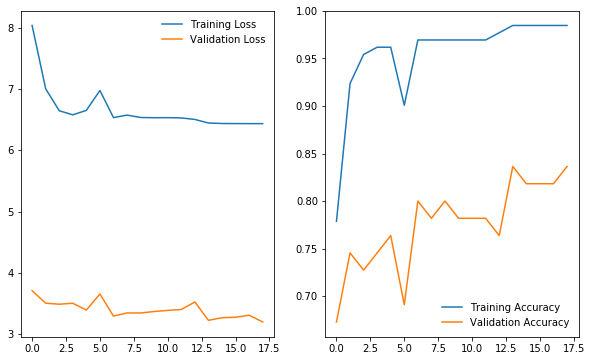

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.plot(train_losses,label='Training Loss')
ax1.plot(valid_losses,label='Validation Loss')

ax1.legend(frameon=False)

ax2.plot(train_acc,label='Training Accuracy')
ax2.plot(valid_acc,label='Validation Accuracy')

ax2.legend(frameon=False)

In [24]:
model.load_state_dict(torch.load("emojify.pkl"))

<All keys matched successfully>

In [25]:
x_test = np.array(['not feeling happy', 'Holy shit', 'you are so pretty', 'let us play ball'])
X_test_indices = sentences_to_indices(x_test, word_to_index, 10)
X_test_indices = torch.from_numpy(X_test_indices)
X_test_indices = Variable(X_test_indices.long()).cuda()
states = (Variable(torch.zeros(2, 4, 128)).cuda(), Variable(torch.zeros(2, 4, 128)).cuda())
pred = model(X_test_indices,states)
pred=pred.cpu()
for i in range(len(x_test)):
    num = np.argmax(pred.data[i])
    print(' prediction: ' + x_test[i] + ' '+emoji.emojize(emoji_dictionary[str(num.item())],use_aliases=True))

 prediction: not feeling happy 😞
 prediction: Holy shit 😄
 prediction: you are so pretty 😞
 prediction: let us play ball ⚾


In [26]:
while True:
    st=input()
    X_test_indices = sentences_to_indices(np.array([st]), word_to_index, 10)
    X_test_indices = torch.from_numpy(X_test_indices)
    X_test_indices = Variable(X_test_indices.long()).cuda()
    states = (Variable(torch.zeros(2, 1, 128)).cuda(), Variable(torch.zeros(2, 1, 128)).cuda())
    pred = model(X_test_indices,states)
    pred=pred.cpu()
    num = np.argmax(pred.data)
    print(' prediction: ' + st + ' '+emoji.emojize(emoji_dictionary[str(num.item())],use_aliases=True))
    print("Again?")
    retry=input()
    if retry=="no":
        break

StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.